# Importing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import config
from data_io import load_data

In [ ]:
spam_data = load_data('data/spam_data.csv')
spam_data.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,full_message
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni... nan nan nan
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


concat 2-4 columns and fiw column name

In [50]:
columns_to_join = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
existing_columns = [col for col in columns_to_join if col in spam_data.columns]
spam_data['full_message'] = spam_data[existing_columns].apply(
    lambda row: ' '.join(row.dropna().astype(str)), axis=1
)
spam_data = spam_data[['v1', 'full_message']].rename(columns={'v1': 'label', 'full_message': 'message'})

In [51]:
spam_data.describe()


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [52]:
spam_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [53]:
spam_data['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

# Adding new columns to the analysis

In [54]:
spam_data['message_length'] = spam_data['message'].apply(len)
spam_data['num_words'] = spam_data['message'].apply(lambda x: len(x.split()))

# Message length distribution

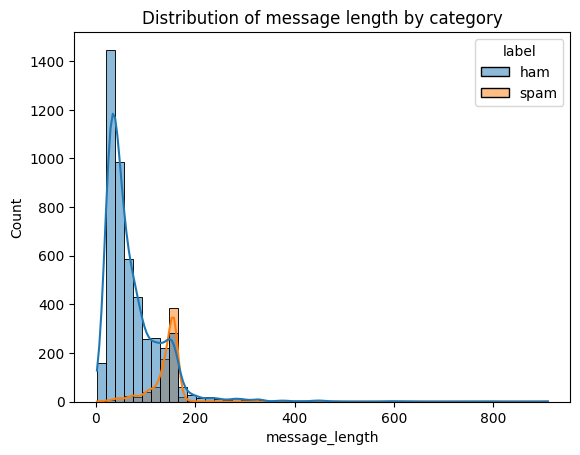

In [55]:
sns.histplot(data=spam_data, x='message_length', hue='label', bins=50, kde=True)
plt.title('Distribution of message length by category')
plt.show()

# Distribution of the number of words in a message 

(not just its length in characters)

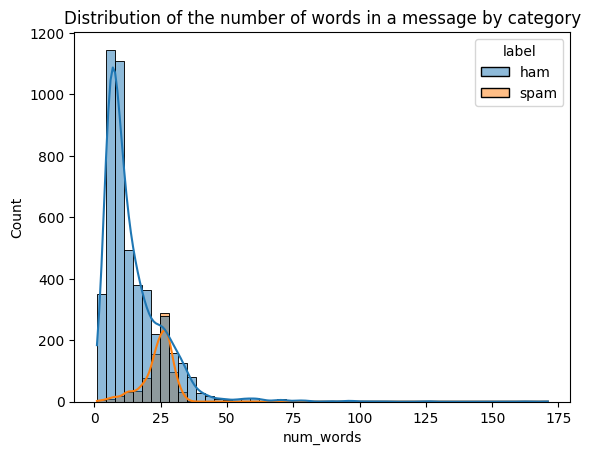

In [56]:
sns.histplot(data=spam_data, x='num_words', hue='label', bins=50, kde=True)
plt.title("Distribution of the number of words in a message by category")
plt.show()

# Word frequency by category

In [57]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

spam_data['cleaned'] = spam_data['message'].apply(clean_text)

ham_words = ' '.join(spam_data[spam_data['label']=='ham']['cleaned']).split()
spam_words = ' '.join(spam_data[spam_data['label']=='spam']['cleaned']).split()

ham_freq = Counter(ham_words)
spam_freq = Counter(spam_words)

print("Top ham words:", ham_freq.most_common(10))
print("Top spam words:", spam_freq.most_common(10))

Top ham words: [('i', 2194), ('you', 1841), ('to', 1562), ('the', 1129), ('a', 1063), ('u', 987), ('and', 849), ('in', 815), ('me', 761), ('my', 747)]
Top spam words: [('to', 689), ('a', 378), ('call', 347), ('you', 287), ('your', 263), ('free', 216), ('the', 204), ('for', 203), ('now', 189), ('or', 188)]


# Comparative statistics

In [58]:
spam_data.groupby('label')[['message_length', 'num_words']].describe()

message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
ham           4825.0   71.640622  58.458559   2.0   33.0   52.0   93.0  910.0   
spam           747.0  139.157965  28.981074  13.0  133.0  149.0  158.0  224.0   

      num_words                                                      
          count       mean        std  min   25%   50%   75%    max  
label                                                                
ham      4825.0  14.312953  11.513848  1.0   7.0  11.0  19.0  171.0  
spam      747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0

# Bigrams/trigrams frequency analysis

Instead of checking just single words, you can check pairs or triplets of words that are repeated.

In [59]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_spam = vectorizer.fit_transform(spam_data[spam_data['label'] == 'spam']['cleaned'])
bigrams = vectorizer.get_feature_names_out()

bigr_counts = np.asarray(X_spam.sum(axis=0)).flatten()
top_bigrams = sorted(zip(bigr_counts, bigrams), reverse=True)[:10]
print("Top spam bigrams:", top_bigrams)

Top spam bigrams: [(27, 'po box'), (25, '1000 cash'), (22, 'prize guaranteed'), (21, 'send stop'), (19, 'selected receive'), (19, 'await collection'), (18, 'urgent mobile'), (18, 'land line'), (17, 'valid 12hrs'), (17, 'customer service')]


# Messages by keyword presence

List suspicious words such as win, prize, urgent, free
and then check how many spam and ham messages contain one of them.

In [ ]:
keywords = config.keywords

spam_data['has_keyword'] = spam_data['cleaned'].apply(
    lambda x: any(word in x for word in keywords)
)

spam_data.groupby('label')['has_keyword'].mean()


label
ham     0.090777
spam    0.808568
Name: has_keyword, dtype: float64

# Use of capital letters (CAPS)

Spam likes to attract attention, so it's worth checking how many capitalized words there are in each message.

In [61]:
spam_data['num_uppercase'] = spam_data['message'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
spam_data[['label', 'num_uppercase']].groupby('label').mean()


,num_uppercase
label,
ham,0.853057
spam,2.622490


# Use of numbers or special characters

Do numbers appear (like £1000, 50%)

How often are there symbols like !, $, %, @

In [62]:
spam_data['num_exclamations'] = spam_data['message'].apply(lambda x: x.count('!'))
spam_data['num_digits'] = spam_data['message'].apply(lambda x: len(re.findall(r'\d+', x)))


<Axes: >

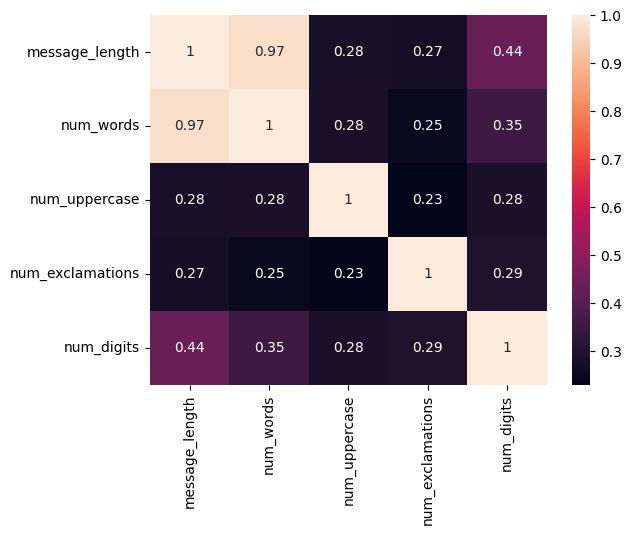

In [65]:
corr = spam_data[['message_length', 'num_words', 'num_uppercase', 'num_exclamations', 'num_digits']].corr()
sns.heatmap(corr, annot=True)


In [66]:
spam_data.head()

,label,message,message_length,num_words,cleaned,has_keyword,num_uppercase,num_exclamations,num_digits
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go until jurong point crazy available only in ...,False,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni,False,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry in 2 a wkly comp to win fa cup fina...,True,2,0,6
3,ham,U dun say so early hor... U c already then say...,49,11,u dun say so early hor u c already then say,False,2,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah i dont think he goes to usf he lives aroun...,False,1,0,0


# Adding New Features to check corr

In [ ]:

# Preparing a list of suspicious bigrams
suspicious_bigrams = config.suspicious_bigrams
# Function to check for suspicious bigrams in a text
def contains_suspicious_bigram(text):
    for bigram in suspicious_bigrams:
        if bigram in text:
            return 1
    return 0

# binary feature
spam_data['has_suspicious_bigram'] = spam_data['cleaned'].apply(contains_suspicious_bigram)

# numerical feature
def count_suspicious_bigrams(text):
    return sum(1 for bigram in suspicious_bigrams if bigram in text)

spam_data['count_suspicious_bigrams'] = spam_data['cleaned'].apply(count_suspicious_bigrams)

# new feature - number of uppercase words
spam_data['uppercase_ratio'] = spam_data['num_uppercase'] / spam_data['num_words'].replace(0, 1)

# number or special characters 
spam_data['digit_ratio'] = spam_data['num_digits'] / spam_data['num_words'].replace(0, 1)
spam_data['exclam_ratio'] = spam_data['num_exclamations'] / spam_data['message'].apply(len).replace(0, 1)

# Presence of question/command words
question_words = config.question_words
spam_data['has_question_word'] = spam_data['cleaned'].apply(lambda x: any(w in x.split() for w in question_words))
spam_data['has_question_mark'] = spam_data['message'].apply(lambda x: '?' in x).astype(int)

# Does the message end with a word like "stop" (common in spam)
spam_data['ends_with_stop'] = spam_data['cleaned'].apply(lambda x: x.strip().endswith('stop')).astype(int)

spam_data.columns

Index(['label', 'message', 'message_length', 'num_words', 'cleaned',
       'has_keyword', 'num_uppercase', 'num_exclamations', 'num_digits',
       'has_suspicious_bigram', 'count_suspicious_bigrams', 'uppercase_ratio',
       'digit_ratio', 'exclam_ratio', 'has_question_word', 'has_question_mark',
       'ends_with_stop'],
      dtype='object')

<Axes: >

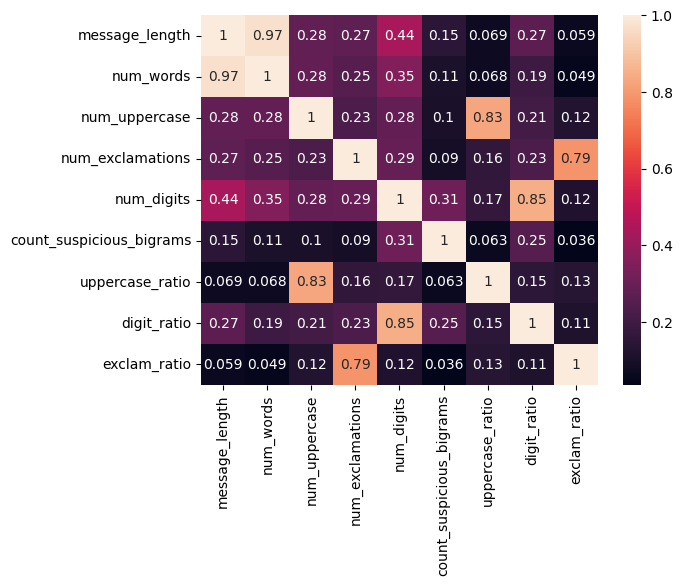

In [71]:
corr = spam_data[['message_length', 'num_words','num_uppercase', 'num_exclamations', 'num_digits',
    'count_suspicious_bigrams', 'uppercase_ratio','digit_ratio', 'exclam_ratio']].corr()
sns.heatmap(corr, annot=True)